# Configuration

In [1]:
%load_ext autoreload
%autoreload 2

from log_processing.split import split_BGL_raw_logs, split_HDFS_raw_logs, create_clients_data
from log_processing.parse import LogParser
from log_processing.sample import BGL_sampling, HDFS_sampling, split_train_test_logs
from log_processing.embedding import LogEmbedder, EmbeddingReducer, ClientEmbedder
from model_training.read_data import read
from model_training.train import train, get_predictions
from visualization.plot import *
from consensus.network import create_specific_undirected_graph, create_random_undirected_graph, plot_eigenvalues, plot_network
from pinns.model import hard_constraint
import os
import torch
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import itertools
from sklearn.calibration import calibration_curve
import scipy.io
print("Libraries correctly imported!")

Libraries correctly imported!


In [2]:
# Change dataset and parser (BGL, HDFS)
dataset = 'HDFS'
data_dir = 'Data/' + dataset

# Choose the parser
# Spell for HDFS
# IPLoM or Drain for BGL
logparser = 'Spell'

# Choose the number of clients (local servers)
K = 5

# raw logs paths
raw_data_dir = '../Raw_data_logs/' + dataset +'/'
raw_data = raw_data_dir + dataset + '.log'
labels = raw_data_dir + 'anomaly_label.csv'
raw_data_normal = raw_data_dir + dataset + '_normal.log'
raw_data_abnormal = raw_data_dir + dataset + '_abnormal.log'

# models paths
models_dir = 'Models/' + dataset
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
w2v_models_dir = models_dir + '/word2vec_models/'
if not os.path.exists(w2v_models_dir):
    os.makedirs(w2v_models_dir)
tcn_models_dir = models_dir + '/TCN_models/'
if not os.path.exists(tcn_models_dir):
    os.makedirs(tcn_models_dir)

# raw clients data path
raw_data_clients_dir = data_dir + '/clients_raw_data/'
if not os.path.exists(raw_data_clients_dir):
    os.makedirs(raw_data_clients_dir)

# parsed logs path
parsed_data_dir = data_dir + '/parsed_data/'
if not os.path.exists(parsed_data_dir):
    os.makedirs(parsed_data_dir)
    
# embedded logs
embedded_data_dir = data_dir + '/embedded_data/'
if not os.path.exists(embedded_data_dir):
    os.makedirs(embedded_data_dir)
semantic_dim_high = 300
semantic_dim_low = 20

# processed logs for lightlog
processed_data_dir = data_dir + '/processed_data/'
if not os.path.exists(processed_data_dir):
    os.makedirs(processed_data_dir)
processed_validation_data = processed_data_dir + '/validation_data.csv'

# plots path
plots_dir = 'Plots/'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
print("Paths correctly defined!")

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Paths correctly defined!
Using cuda device


# Log Processing

**STAGE 1:** Collect raw logs of K client.

Each client is seen as an independent local server, which processes and trains its dataset.

Given a single big dataset, discriminate the normal and abnormal logs and create K client datasets, each one with a the same proportion of normal and abnormal logs.

In [8]:
logs = raw_data
label_file = labels
normal_logs_file = raw_data_normal
anomaly_logs_file = raw_data_abnormal

if dataset == 'BGL':
    split_BGL_raw_logs(
                   logs,\
                   normal_logs_file,\
                   anomaly_logs_file
                  )
elif dataset == 'HDFS':
    split_HDFS_raw_logs(
                   logs,\
                   label_file,\
                   normal_logs_file,\
                   anomaly_logs_file
                  )
else:
    raise ValueError(f'The dataset {dataset} is not recognized.')


normal_logs_file = raw_data_normal
anomaly_logs_file = raw_data_abnormal
output_directory = 	raw_data_clients_dir

create_clients_data(
    normal_logs_file,\
    anomaly_logs_file,\
    output_directory,\
    K
)


there are 16838 abnormal block indices
Number of normal logs: 10887379
Number of abnormal logs: 288250
creating client 1...
created Data/HDFS/clients_raw_data/client_1.log: it has 2235079 logs
creating client 2...
created Data/HDFS/clients_raw_data/client_2.log: it has 2235086 logs
creating client 3...
created Data/HDFS/clients_raw_data/client_3.log: it has 2235075 logs
creating client 4...
created Data/HDFS/clients_raw_data/client_4.log: it has 2235102 logs
creating client 5...
created Data/HDFS/clients_raw_data/client_5.log: it has 2235085 logs


**STAGE 2:** Parse the logs 

In [9]:
parser = LogParser(
    dataset,\
    logparser,\
    clients,\
    parsed_data_dir,\
    raw_data_clients_dir
)
parser.parse_logs()

Parser: Spell
Parsing file: Data/HDFS/clients_raw_data/client_1.log
Processed 0.0% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.3% of log lines.
Processed 0.3% of log lines.
Processed 0.4% of log lines.
Processed 0.4% of log lines.
Processed 0.4% of log lines.
Processed 0.5% of log lines.
Processed 0.5% of log lines.
Processed 0.6% of log lines.
Processed 0.6% of log lines.
Processed 0.7% of log lines.
Processed 0.7% of log lines.
Processed 0.8% of log lines.
Processed 0.8% of log lines.
Processed 0.9% of log lines.
Processed 0.9% of log lines.
Processed 0.9% of log lines.
Processed 1.0% of log lines.
Processed 1.0% of log lines.
Processed 1.1% of log lines.
Processed 1.1% of log lines.
Processed 1.2% of log lines.
Processed 1.2% of log lines.
Processed 1.3% of log lines.
Processed 1.3% of log lines.
Processed 1.3% of log lines.
Processed 1.4% of log lines.
Processed 1.4% of log lines.
Proc

**STAGE 3:** For each i-th local server, sample and split its i-th structured dataset based on the dataset itself ( HDFS or BGL ):

* BGL dataset (4.713.493 logs):
    -   Do not record the block ID generated by each log event, therefore they can be divided in labeled sequences using a sliding window
    -   Knowing that clients have at least 34022 normal sessions and 2787 abnormal sessions, split the i-th dataset such that:   
    -   Train set has 4000 log sessions (2000 abnormal & 2000 normal) and
    -   Test set is composed by 32809 log sessions (32022 normal and 787 abnormal, such that the percentage of abnormal log sessions is ≈1.9%)


* HDFS dataset (11.175.629 logs):
    -   Contains block ID information, so it is suitable for grouping each session by block_id.
    -   Knowing that clients have at least 102697 normal sessions and 3990 abnormal sessions, split the i-th dataset such that:
    -   Train set has 6000 log sessions (3000 abnormal & 3000 normal) and
    -   Test set is composed by 101.450 log sessions (99.697 normal and 1753 abnormal, such that the percentage of abnormal log sessions is ≈1.9%)

*block_id represents a designated hard disk storage space*


In [3]:
# Label each structured local dataset (depending on the type of data)
# Using the function '{dataset}_sampling()'
if dataset == 'BGL':
    # Parameters for sampling with sliding window (only for BGL)
    window_size = 50
    step_size = 25
    threshold = 1

    # Parameters for splitting
    n_train = 2000
    n_test_normal = 32022
    n_test_abnormal = 787

    for i in range(0,K):
        # Define input and output files for i-th client data labeling
        structured_client_data = parsed_data_dir + f'client_data_{i+1}/client_{i+1}.log_structured.csv'
        labeled_client_data = parsed_data_dir + f'client_data_{i+1}/client_{i+1}.log_labeled.csv'

        BGL_sampling(
            structured_client_data,\
            labeled_client_data,\
            window_size,\
            step_size,\
            threshold
        )

elif dataset == 'HDFS':
    # Parameters for splitting (5 clients)
    if K == 5:
        n_train_abnormal = 3000
        n_train_normal = 24000
        n_test_normal = 78697
        n_test_abnormal = 2000
    # Parameters for splitting (1 client)
    elif K == 1:
        n_train = 6000
        n_test_normal = 490000
        n_test_abnormal = 10000
    # Parameters for splitting (2 clients)
    else:
        n_train = 6000
        n_test_normal = 263044 - 6000
        n_test_abnormal = 3320

    for i in range(0,K):
        # Define input and output files for i-th client data labeling
        structured_client_data = parsed_data_dir + f'client_data_{i+1}/client_{i+1}.log_structured.csv'
        labeled_client_data = parsed_data_dir + f'client_data_{i+1}/client_{i+1}.log_labeled.csv'

        HDFS_sampling(
            structured_client_data,\
            labels,\
            labeled_client_data
        )
else:
    raise ValueError(f'The dataset {dataset} is not recognized.')


# Create K train and test datasets (one for each client)
# Using the function 'split_train_test_logs()'
for i in range(0,K):
    # Define input and output files for i-th client data labeling
    labeled_client_data = parsed_data_dir + f'client_data_{i+1}/client_{i+1}.log_labeled.csv'
    processed_client_data_dir = processed_data_dir + f'client_data_{i+1}/'
    if not os.path.exists(processed_client_data_dir):
        os.makedirs(processed_client_data_dir)
    processed_client_data_train = processed_client_data_dir + f'client_{i+1}_train.csv'
    processed_client_data_test = processed_client_data_dir + f'client_{i+1}_test.csv'

    split_train_test_logs(
        i+1,\
        labeled_client_data,\
        processed_client_data_train,\
        processed_client_data_test,\
        processed_validation_data,\
        n_train_normal,\
        n_train_abnormal,\
        n_test_normal,\
        n_test_abnormal,\
        K
    )

* Creating labeled sequences for Data/HDFS/parsed_data/client_data_1/client_1.log_structured.csv...Done!
  - Total number of sequences: 108046
  - Number of normal sequences: 102697
  - Number of abnormal sequences: 5349

* Creating labeled sequences for Data/HDFS/parsed_data/client_data_2/client_2.log_structured.csv...Done!
  - Total number of sequences: 208934
  - Number of normal sequences: 203520
  - Number of abnormal sequences: 5414

* Creating labeled sequences for Data/HDFS/parsed_data/client_data_3/client_3.log_structured.csv...Done!
  - Total number of sequences: 213242
  - Number of normal sequences: 209252
  - Number of abnormal sequences: 3990

* Creating labeled sequences for Data/HDFS/parsed_data/client_data_4/client_4.log_structured.csv...Done!
  - Total number of sequences: 191925
  - Number of normal sequences: 186544
  - Number of abnormal sequences: 5381

* Creating labeled sequences for Data/HDFS/parsed_data/client_data_5/client_5.log_structured.csv...Done!
  - Tot

In [4]:
embedder = LogEmbedder(
    vector_size=300,\
    window=5,\
    min_count=0,\
    workers=4,\
    alpha=0.01,\
    epochs=10
)
ppa_processor = EmbeddingReducer(
    n_components=19,\
    n_directions=7
)
for i in range(1, K + 1):
    client_embedder = ClientEmbedder(
        i,\
        parsed_data_dir,\
        embedded_data_dir,\
        w2v_models_dir,\
        embedder,\
        ppa_processor
    )
    client_embedder.train_word2vec_model()
    client_embedder.apply_ppa()


* Train word2vec model for client 1...
- Loss after epoch 1: 318.0913391113281
- Loss after epoch 2: 313.8719177246094
- Loss after epoch 3: 289.1043701171875
- Loss after epoch 4: 293.2257080078125
- Loss after epoch 5: 293.2501220703125
- Loss after epoch 6: 296.74560546875
- Loss after epoch 7: 337.53515625
- Loss after epoch 8: 350.279296875
- Loss after epoch 9: 326.426513671875
- Loss after epoch 10: 324.12744140625
- Done! Associating to each template sequence the corresponding embedded sequence for client 1...Done!
- Cosine similarity between the first two embeddings: 1.0000

* Applying PPA to client 1...
- Logs of this client are classified in 21 keys
- Length of each high dim semantic vector: 300
- Algorithm terminated: length of each low dim semantic vector: 19

* Train word2vec model for client 2...
- Loss after epoch 1: 266.4819641113281
- Loss after epoch 2: 275.0625915527344
- Loss after epoch 3: 288.277099609375
- Loss after epoch 4: 216.9664306640625
- Loss after epoc

# Training phase

Read the processed data

In [4]:
train_valid_split = 0.8
data = read(
    K,
    processed_data_dir,
    embedded_data_dir,
    processed_validation_data,
    device,
    train_valid_split
)
x_train, y_train, x_valid, y_valid, x_valid_glob, y_valid_glob, x_test, y_test = data


* Client 1
  - Reading train and validation data of client 1...Done! Performed in 2.9635s!
  - Reading test data of client 1...Done! Performed in 9.6083s!

* Client 2
  - Reading train and validation data of client 2...Done! Performed in 2.6549s!
  - Reading test data of client 2...Done! Performed in 8.7477s!

* Client 3
  - Reading train and validation data of client 3...Done! Performed in 2.5311s!
  - Reading test data of client 3...Done! Performed in 8.6105s!

* Client 4
  - Reading train and validation data of client 4...Done! Performed in 2.5708s!
  - Reading test data of client 4...Done! Performed in 8.7574s!

* Client 5
  - Reading train and validation data of client 5...Done! Performed in 2.5505s!
  - Reading test data of client 5...Done! Performed in 8.7337s!

* Reading model validation data...Done!

All the data are successfully read and stored in variables in 59.0108s!
samples per client: [19200, 19200, 19200, 19200, 19200]


Train the clients

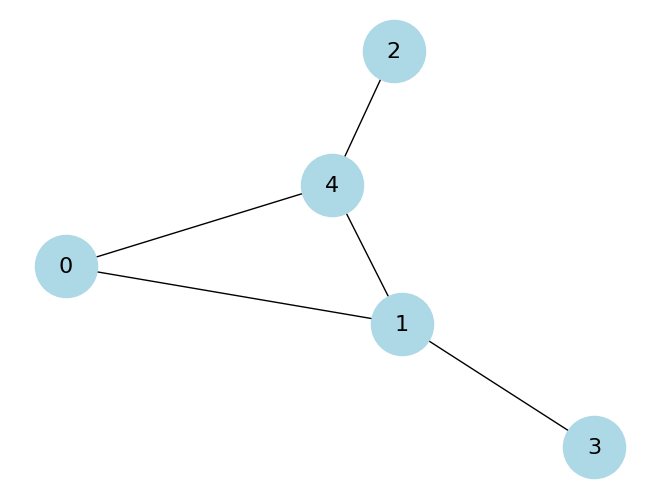

Model training (& testing) performed in 0.0000 min!


In [6]:
# Shape of x_train is: (clients, batch_size, sequence_length[time steps], input_size[channels/features])

# HYPERPARAMETER 
decentralized = False # True for DecAdaLightLog, False for AdaLightLog/FedAvg
update_rule = 'f1' # Must be 'no' for training FedAvg
score = 'f1' # Must be 'no' for training DecAdaLightLog/FedAvg
learning_rate = 0.5 
batch_size = 256
input_size = x_train.shape[2]
communication_rounds = 100
local_epochs = 3

model_path = 'Trained_Integrator_PINNs/Integrator_PINN/model/model.pt'
model_1 = torch.load(model_path)
model_1.eval()
model_path_2 = 'Trained_Integrator_PINNs/Integrator_PINN_lemma2/model/model.pt'
model_2 = torch.load(model_path_2)
model_2.eval()

#A, D, L = create_random_undirected_graph(K, p=0.3)
#plot_network(A)
A, D, L = create_specific_undirected_graph()

delta = 5.4
k1 = 3.5
k2 = 1.4
alpha = 21/25
c = 1
theta = 0.9
consensus_params = {
    "k1": k1,     # Initial gain for v_i
    "k2": k2,     # Initial gain for tanh term
    "delta": delta,
    "alpha": alpha,  # Exponent for v_i (radio of pos ODD numbers)
    "c": c,
    "theta": theta,
    "delta1": delta - k2, # Saturation threshold
    "dt": 0.01,    # Time step size
    "dist": 0.0,
    "A": A,
    "integrator": model_1,
    "integrator_lemma2": model_2
}

train_data = {
    "update_rule": update_rule,\
    "score": score,\
    "input_size": input_size,\
    "x_train": x_train,\
    "y_train": y_train,\
    "x_valid": x_valid,\
    "y_valid": y_valid,\
    "x_test": x_test,\
    "y_test": y_test,\
    "x_valid_glob": x_valid_glob,\
    "y_valid_glob": y_valid_glob,\
    "K": K,\
    "communication_rounds": communication_rounds,\
    "local_epochs": local_epochs,\
    "learning_rate": learning_rate,\
    "batch_size": batch_size,\
    "tcn_models_dir": tcn_models_dir,\
    "device": device,\
    "decentralized": decentralized,\
    "consensus_params": consensus_params 
}
start_data = time.perf_counter()
trained_model, val_loss, val_acc, val_prec, val_rec, val_f1 = train(train_data)
end_data = time.perf_counter()
training_time = (end_data - start_data)/60
print(f'Model training (& testing) performed in {training_time:.4f} min!')


# Validation Phase

Download the json files for the trained models 

In [205]:
def get_mat_files(files, outputs):
    for i in range(0,len(files)):
        with open(files[i], 'r') as f:
            data = json.load(f)   
        matlab_data = {
            'loss': data['loss'],\
            'accuracy': data['accuracy'],\
            'precision': data['precision'],\
            'recall': data['recall'],\
            'f1': data['f1']
        }
        # Salva i dati in un file .mat
        scipy.io.savemat(f'{outputs[i]}', matlab_data)

files = [
    tcn_models_dir+'AdaLightLog/FedAvg_lr=0.005_epochs=100_02/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=accuracy_update=f1_lr=0.005_epochs=100_02/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=accuracy_update=recall_lr=0.005_epochs=100_00/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=accuracy_update=precision_lr=0.005_epochs=100_00/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=accuracy_update=no_lr=0.005_epochs=100_04/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=recall_update=f1_lr=0.005_epochs=100_00/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=precision_update=f1_lr=0.005_epochs=100_00/metrics.json',\
    tcn_models_dir+'AdaLightLog/score=f1_update=f1_lr=0.005_epochs=100_03/metrics.json',\
    tcn_models_dir+'DecAdaLightLog/score=no_update=f1_lr=0.005_epochs=100_01/metrics.json',\
    tcn_models_dir+'DecAdaLightLog/score=no_update=recall_lr=0.005_epochs=100_01/metrics.json',\
    tcn_models_dir+'DecAdaLightLog/score=no_update=precision_lr=0.005_epochs=100_04/metrics.json',\
    tcn_models_dir+'DecAdaLightLog/score=no_update=no_lr=0.005_epochs=100_16/metrics.json'
]

outputs = [
    tcn_models_dir+'Thesis_results/FedAvg.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=accuracy_update=f1.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=accuracy_update=recall.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=accuracy_update=precision.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=accuracy_update=no.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=recall_update=f1.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=precision_update=f1.mat',\
    tcn_models_dir+'Thesis_results/AdaLightLog_score=f1_update=f1.mat',\
    tcn_models_dir+'Thesis_results/DecAdaLightLog_score=no_update=f1.mat',\
    tcn_models_dir+'Thesis_results/DecAdaLightLog_score=no_update=recall.mat',\
    tcn_models_dir+'Thesis_results/DecAdaLightLog_score=no_update=precision.mat',\
    tcn_models_dir+'Thesis_results/DecAdaLightLog_score=no_update=no.mat'
]


get_mat_files(files, outputs)

## Metrics Plots

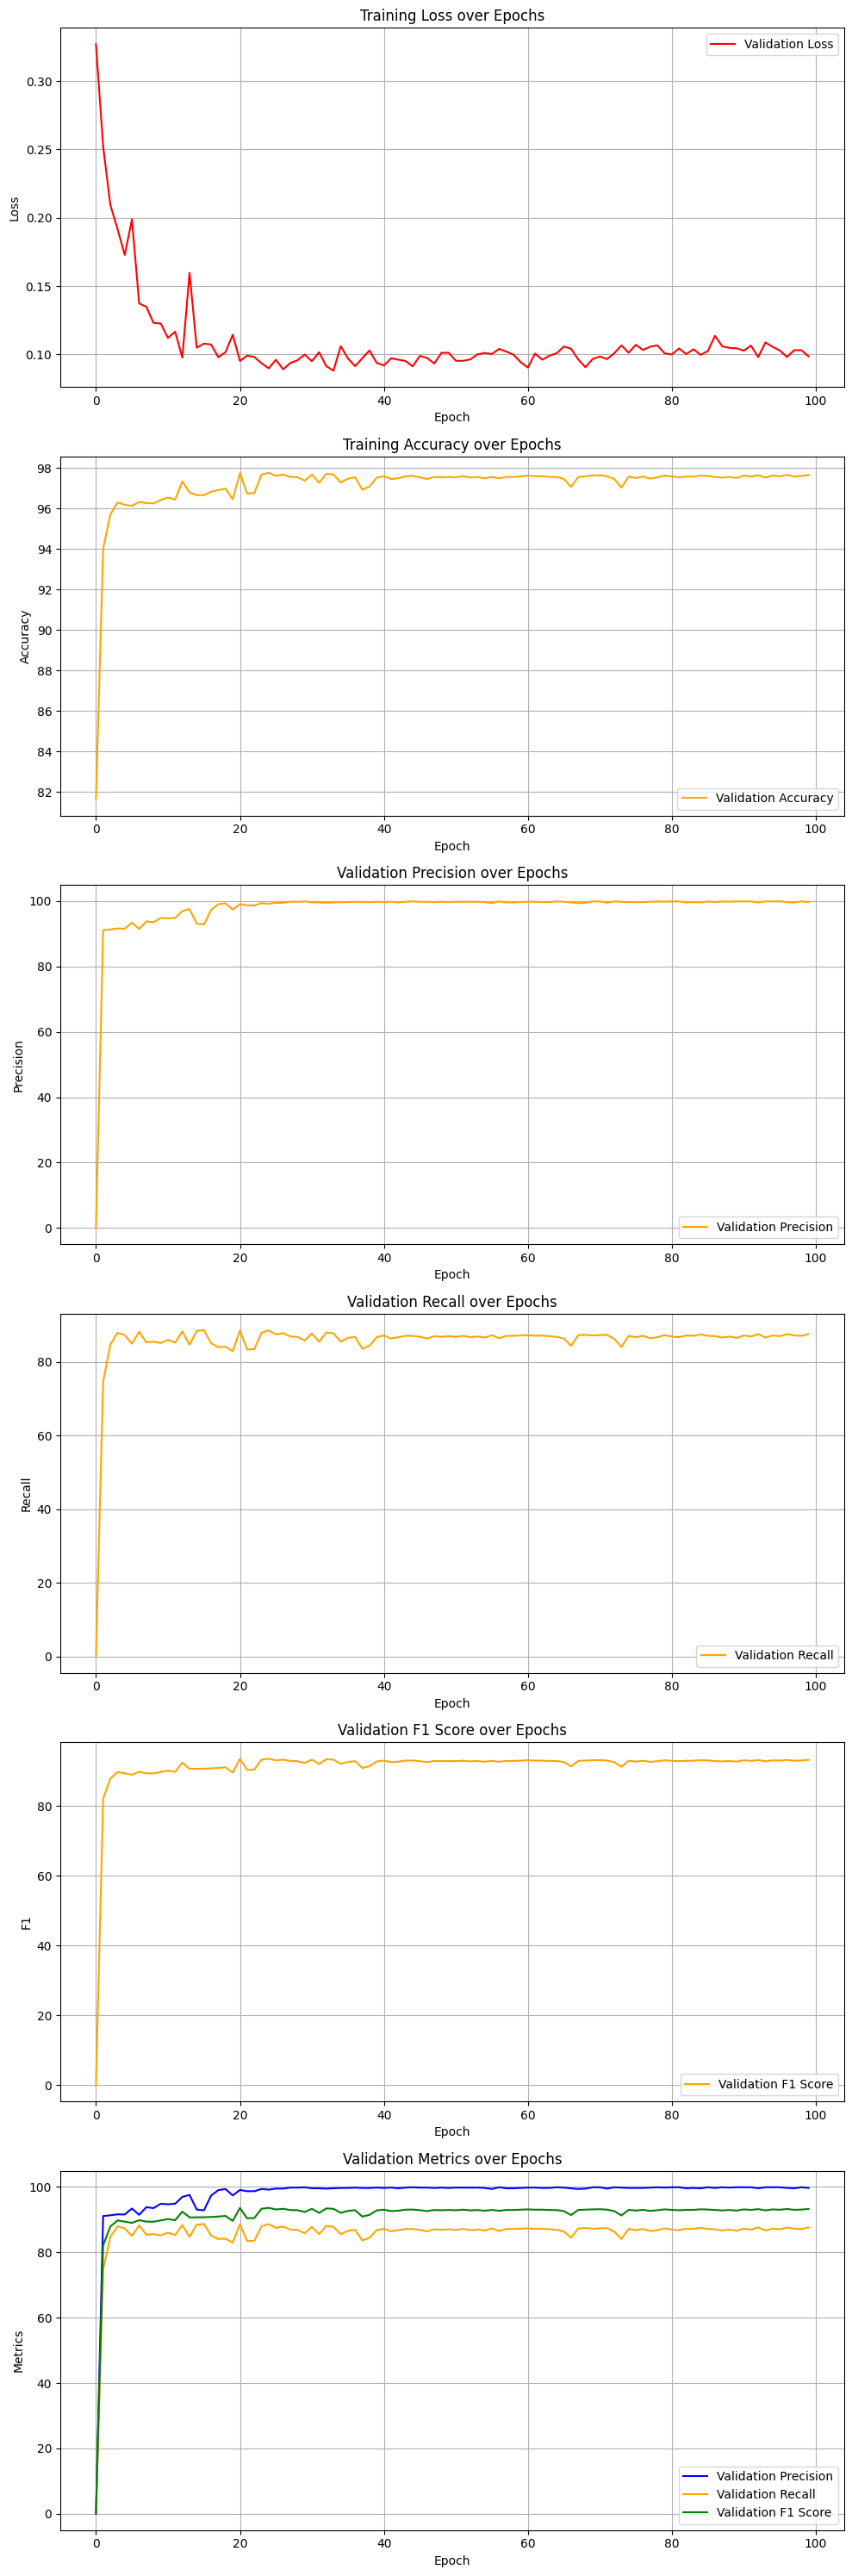

In [52]:
plot_metrics(val_loss, val_acc, val_prec, val_rec, val_f1)

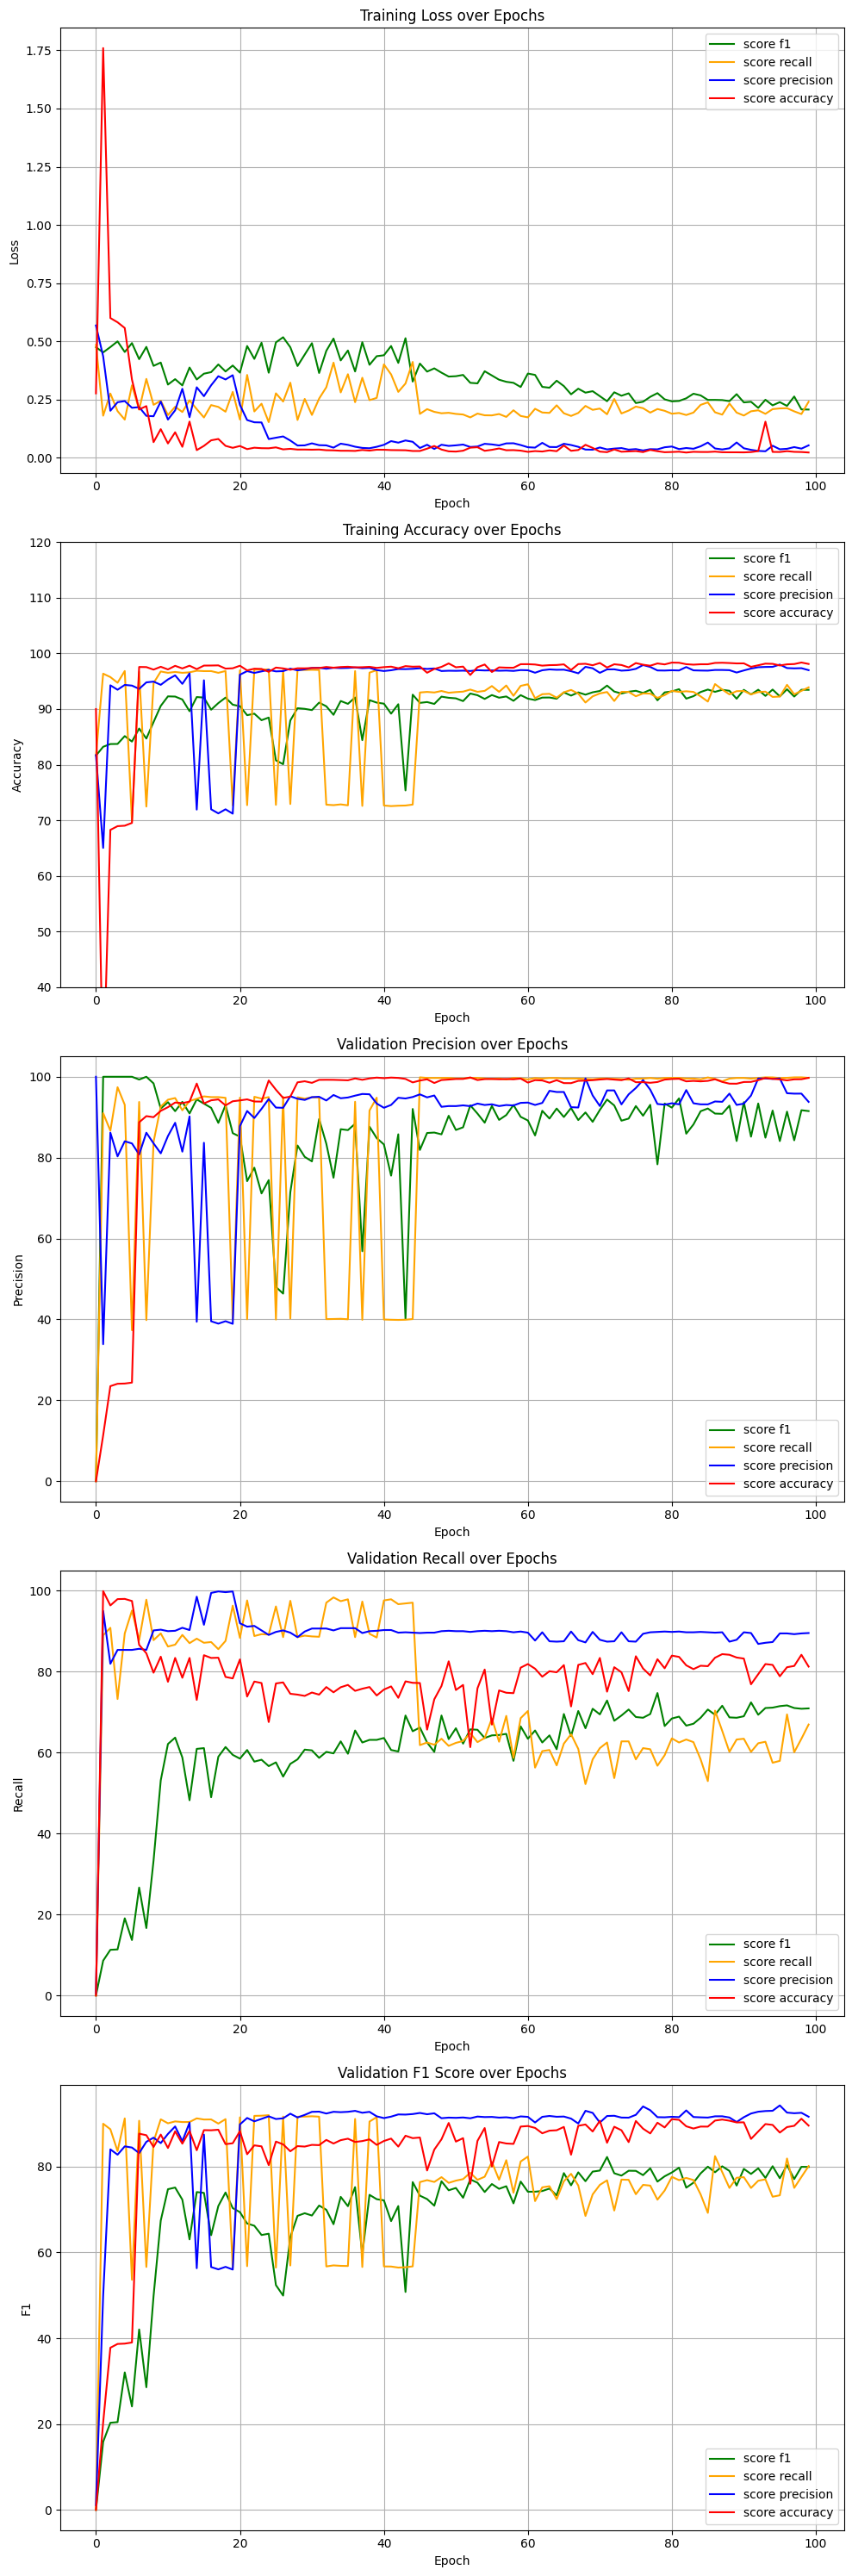

In [64]:
lr1 = "0.005"
ep1 = "100"

# FEDAVG PERFETTO QUESTO
sc1 = "no"
up1 = "no"
num1 = "02"
type1 = "AdaLightLog"

sc2 = "accuracy"
up2 = "f1"
num2 = "03"
type2 = "AdaLightLog"

sc3 = "no"
up3 = "f1"
num3 = "00"
type3 = "DecAdaLightLog"

num4 = "00"
lr4 = "0.5"
compare_metrics_fixed_update(
    f'{tcn_models_dir}{type1}/FedAvg_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'{tcn_models_dir}DecFedAvg/DecFedAvg_lr={lr4}_epochs={ep1}_{num4}/metrics.json',
    f'{tcn_models_dir}{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'{tcn_models_dir}{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json'

)

Plot metrics of a specific model

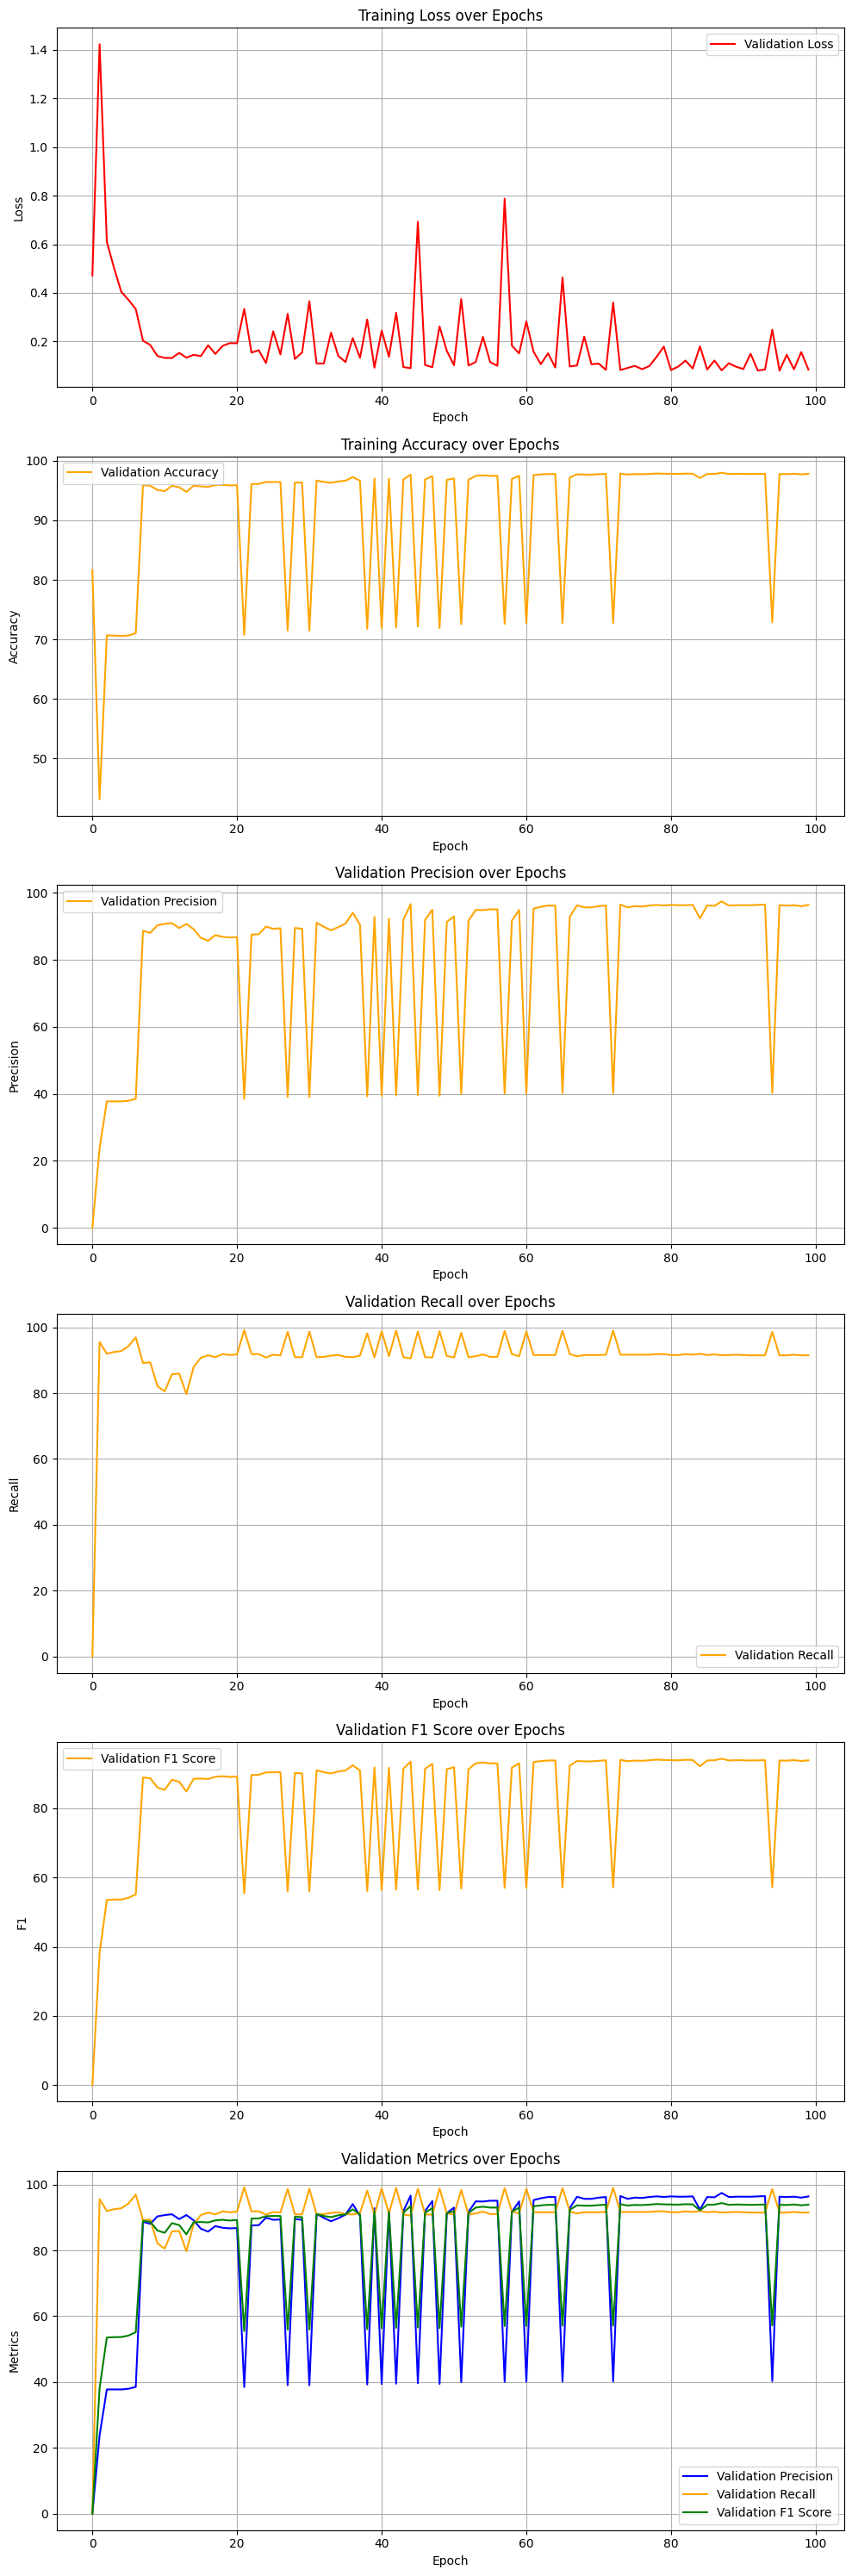

In [166]:
#plot_metrics(val_loss, val_acc, val_prec, val_rec, val_f1)
sc = "no"
up = "no"
lr = "0.005"
ep = "100"
num = "07"
type = "DecAdaLightLog"
if sc == "no" and up == "no" and type == "AdaLightLog":
    path = f'{tcn_models_dir}{type}/FedAvg_lr={lr}_epochs={ep}_{num}/metrics.json'
else:
    path = f'{tcn_models_dir}{type}/score={sc}_update={up}_lr={lr}_epochs={ep}_{num}/metrics.json'
#path = 'Models/HDFS/TCN_models/DecAdaLightLog_score=accuracy_update=precision_lr=0.005_epochs=400_00/metrics.json'
plot_loaded_metrics(path)

Plot comparison between DecAdaLightLog models, trained by varying update rule

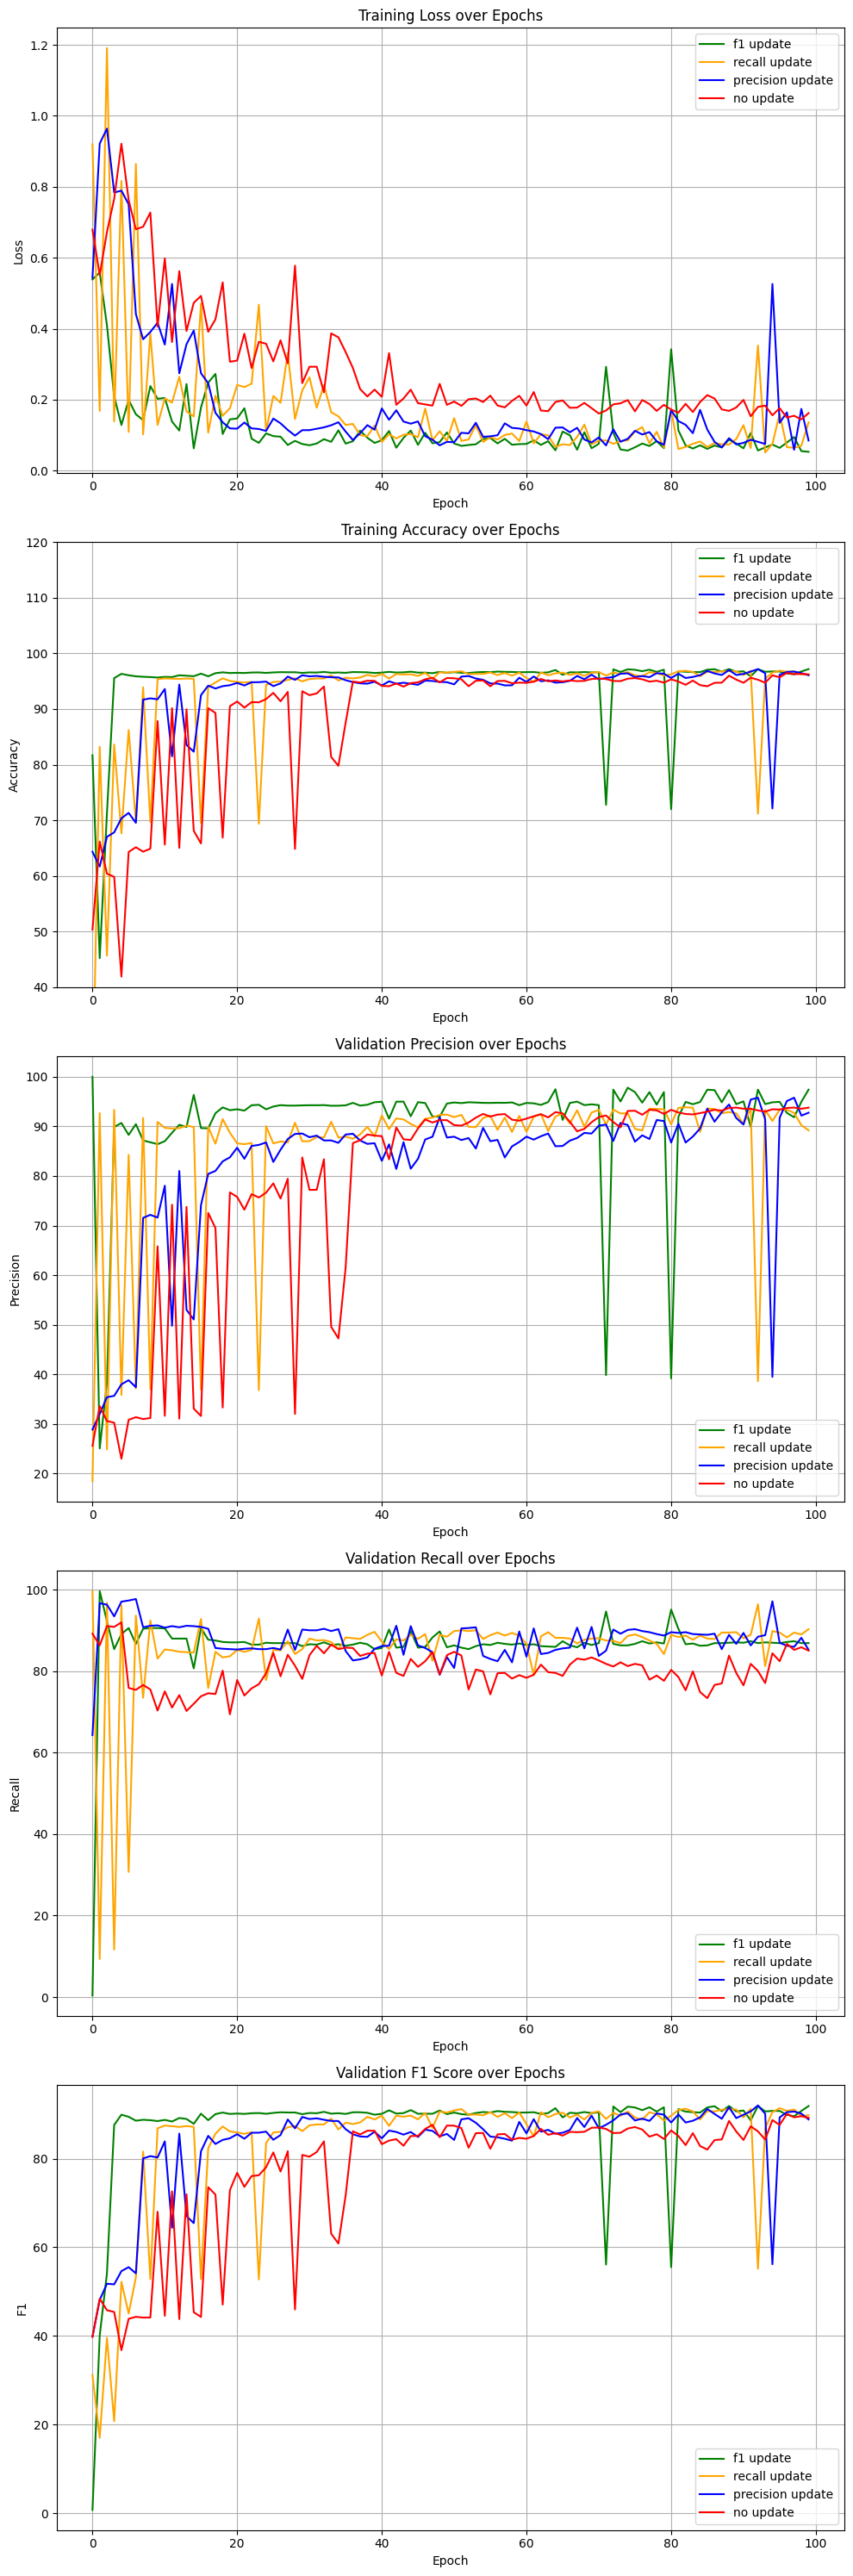

In [197]:
lr1 = "0.005"
ep1 = "100"

sc1 = "no"
up1 = "f1"
num1 = "01"
type1 = "DecAdaLightLog"

sc2 = "no"
up2 = "recall"
num2 = "01"
type2 = "DecAdaLightLog"

sc3 = "no"
up3 = "precision"
num3 = "04"
type3 = "DecAdaLightLog"

sc4 = "no"
up4 = "no"
num4 = "18"
type4 = "DecAdaLightLog"

compare_metrics_fixed_score(
    f'{tcn_models_dir}{type1}/score={sc1}_update={up1}_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'{tcn_models_dir}{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'{tcn_models_dir}{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json',
    f'{tcn_models_dir}{type4}/score={sc4}_update={up4}_lr={lr1}_epochs={ep1}_{num4}/metrics.json'
)


Plot comparison between AdaLightLog models, trained by varying update rule

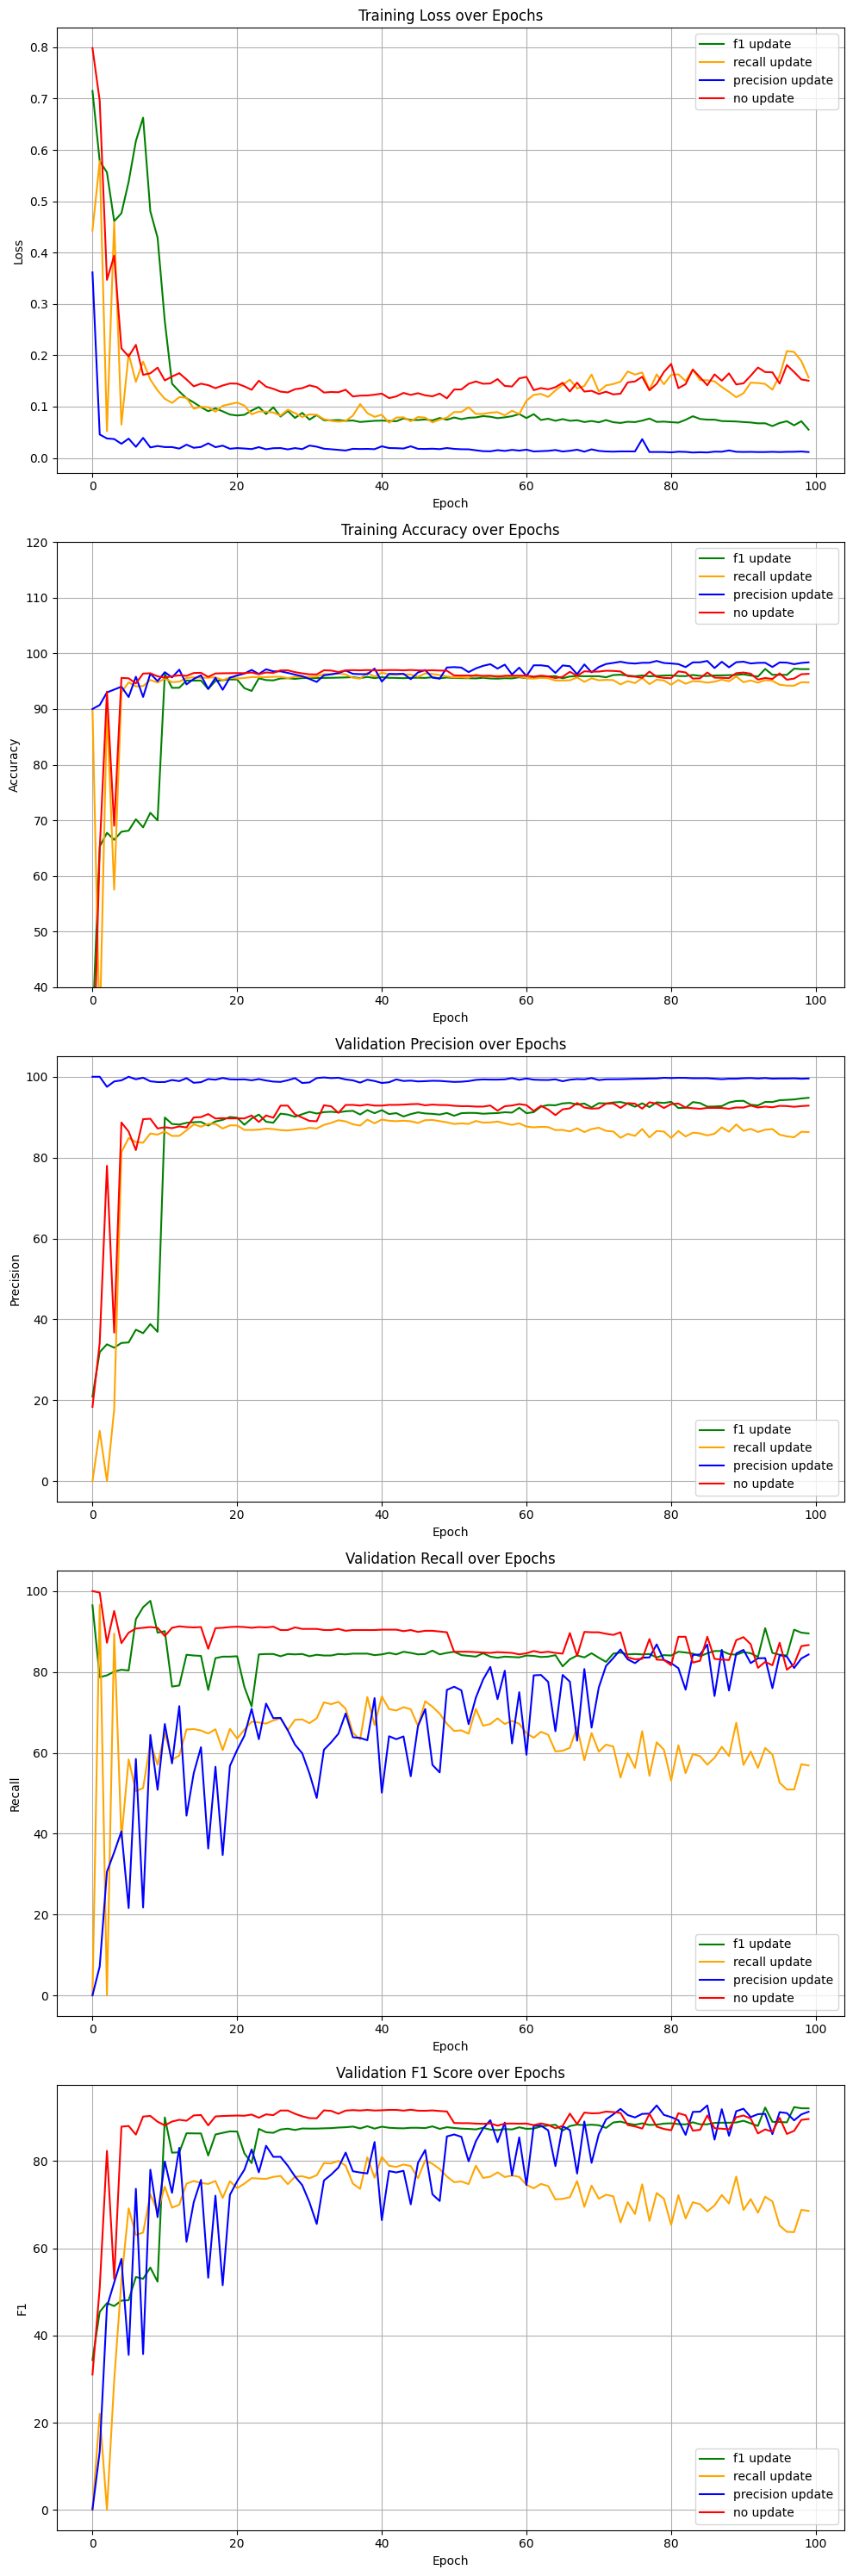

In [164]:
lr1 = "0.005"
ep1 = "100"

sc1 = "accuracy"
up1 = "f1"
num1 = "02"
type1 = "AdaLightLog"

sc2 = "accuracy"
up2 = "recall"
num2 = "00"
type2 = "AdaLightLog"

sc3 = "accuracy"
up3 = "precision"
num3 = "00"
type3 = "AdaLightLog"

sc4 = "accuracy"
up4 = "no"
num4 = "04"
type4 = "AdaLightLog"

compare_metrics_fixed_score(
    f'Models/HDFS/TCN_models/{type1}/score={sc1}_update={up1}_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'Models/HDFS/TCN_models/{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'Models/HDFS/TCN_models/{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json',
    f'Models/HDFS/TCN_models/{type4}/score={sc4}_update={up4}_lr={lr1}_epochs={ep1}_{num4}/metrics.json'
)


Plot comparison between AdaLightLog models, trained by varying weighting score

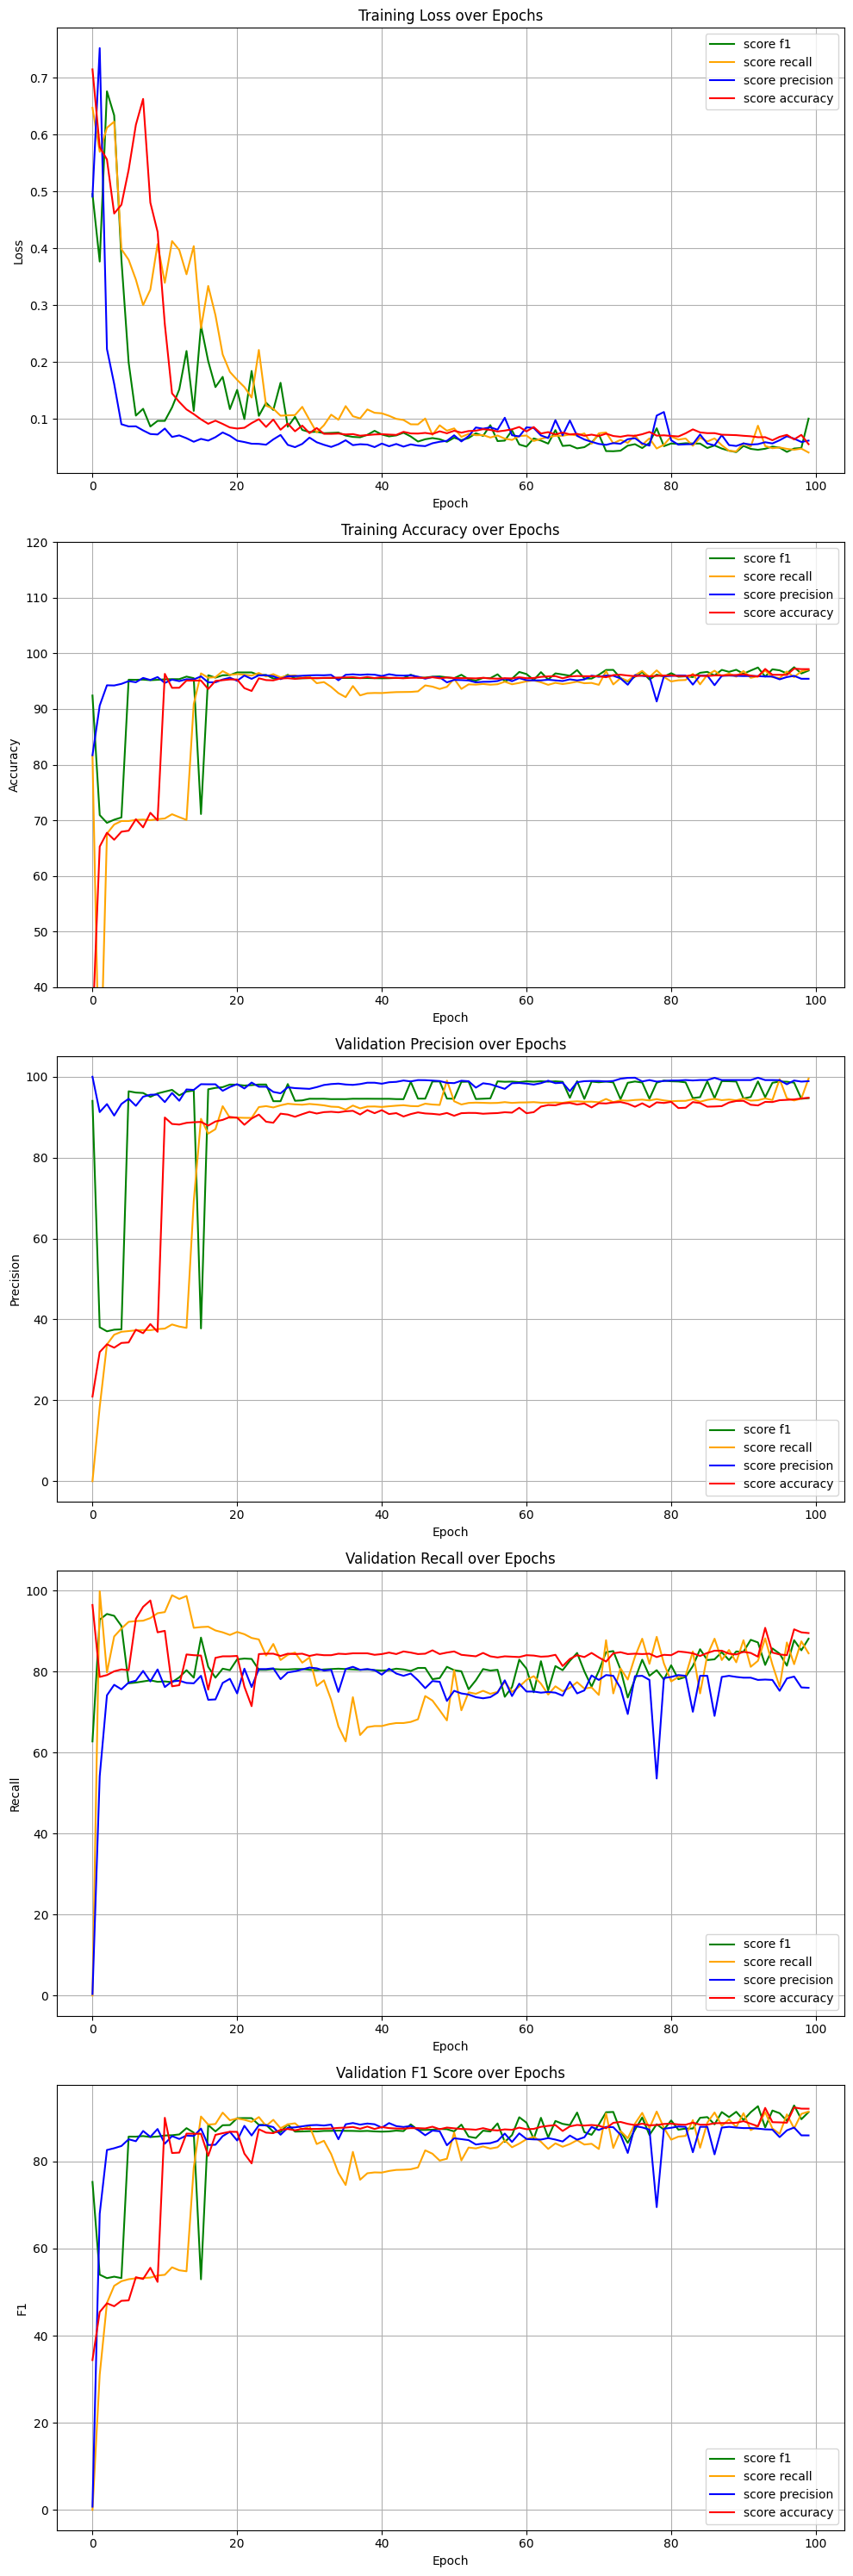

In [204]:
lr1 = "0.005"
ep1 = "100"

sc1 = "f1"
up1 = "f1"
num1 = "03"
type1 = "AdaLightLog"

sc2 = "recall"
up2 = "f1"
num2 = "00"
type2 = "AdaLightLog"

sc3 = "precision"
up3 = "f1"
num3 = "00"
type3 = "AdaLightLog"

sc4 = "accuracy"
up4 = "f1"
num4 = "02"
type4 = "AdaLightLog"

compare_metrics_fixed_update(
    f'Models/HDFS/TCN_models/{type1}/score={sc1}_update={up1}_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'Models/HDFS/TCN_models/{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'Models/HDFS/TCN_models/{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json',
    f'Models/HDFS/TCN_models/{type4}/score={sc4}_update={up4}_lr={lr1}_epochs={ep1}_{num4}/metrics.json'
)


Plot comparison between benchmark FedAvg and proposed AdaLightLog and DecAdaLightLog

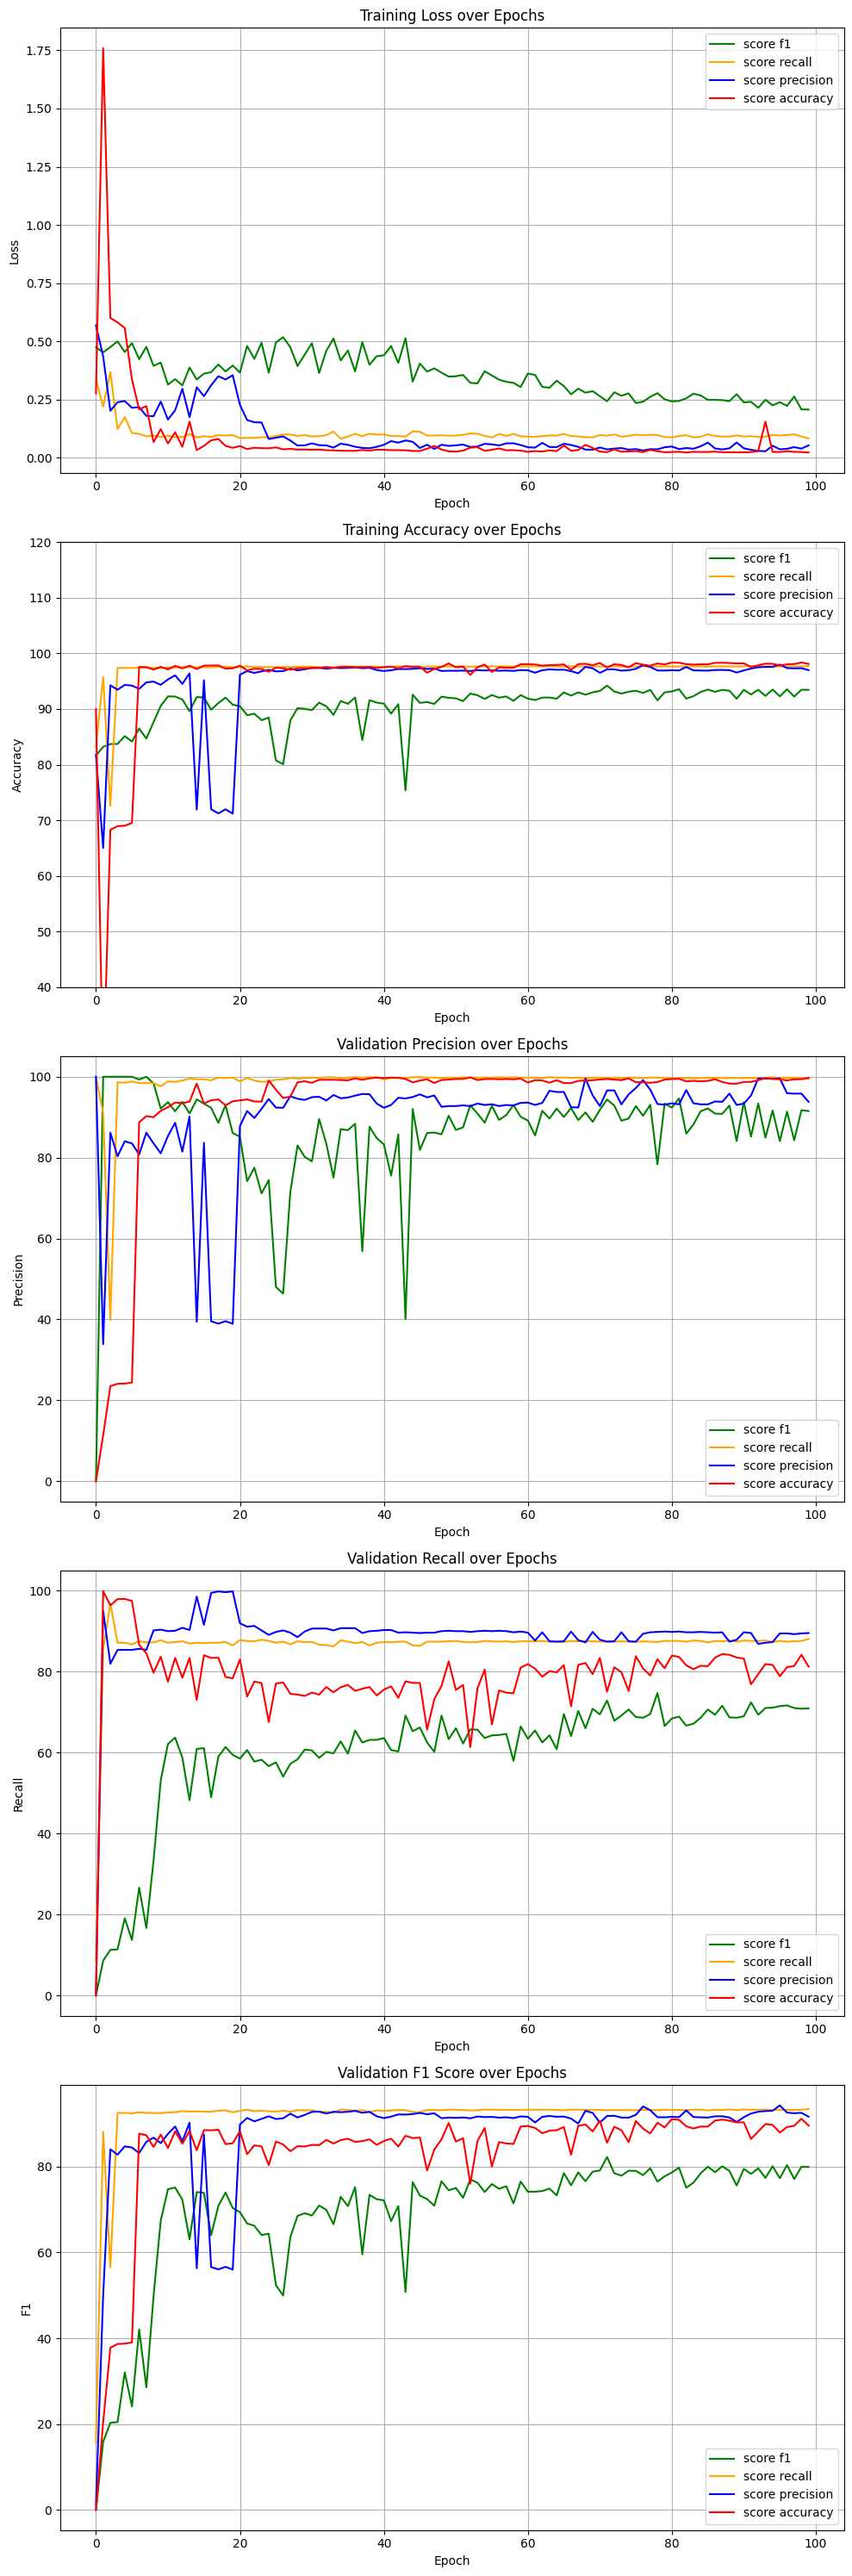

In [18]:
lr1 = "0.005"
ep1 = "100"

# FEDAVG PERFETTO QUESTO
sc1 = "no"
up1 = "no"
num1 = "02"
type1 = "AdaLightLog"

sc2 = "accuracy"
up2 = "f1"
num2 = "03"
type2 = "AdaLightLog"

sc3 = "no"
up3 = "f1"
num3 = "00"
type3 = "DecAdaLightLog"

num4 = "04"
compare_metrics_fixed_update(
    f'{tcn_models_dir}{type1}/FedAvg_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'{tcn_models_dir}DecFedAvg/DecFedAvg_lr={lr1}_epochs={ep1}_{num4}/metrics.json',
    f'{tcn_models_dir}{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'{tcn_models_dir}{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json'

)

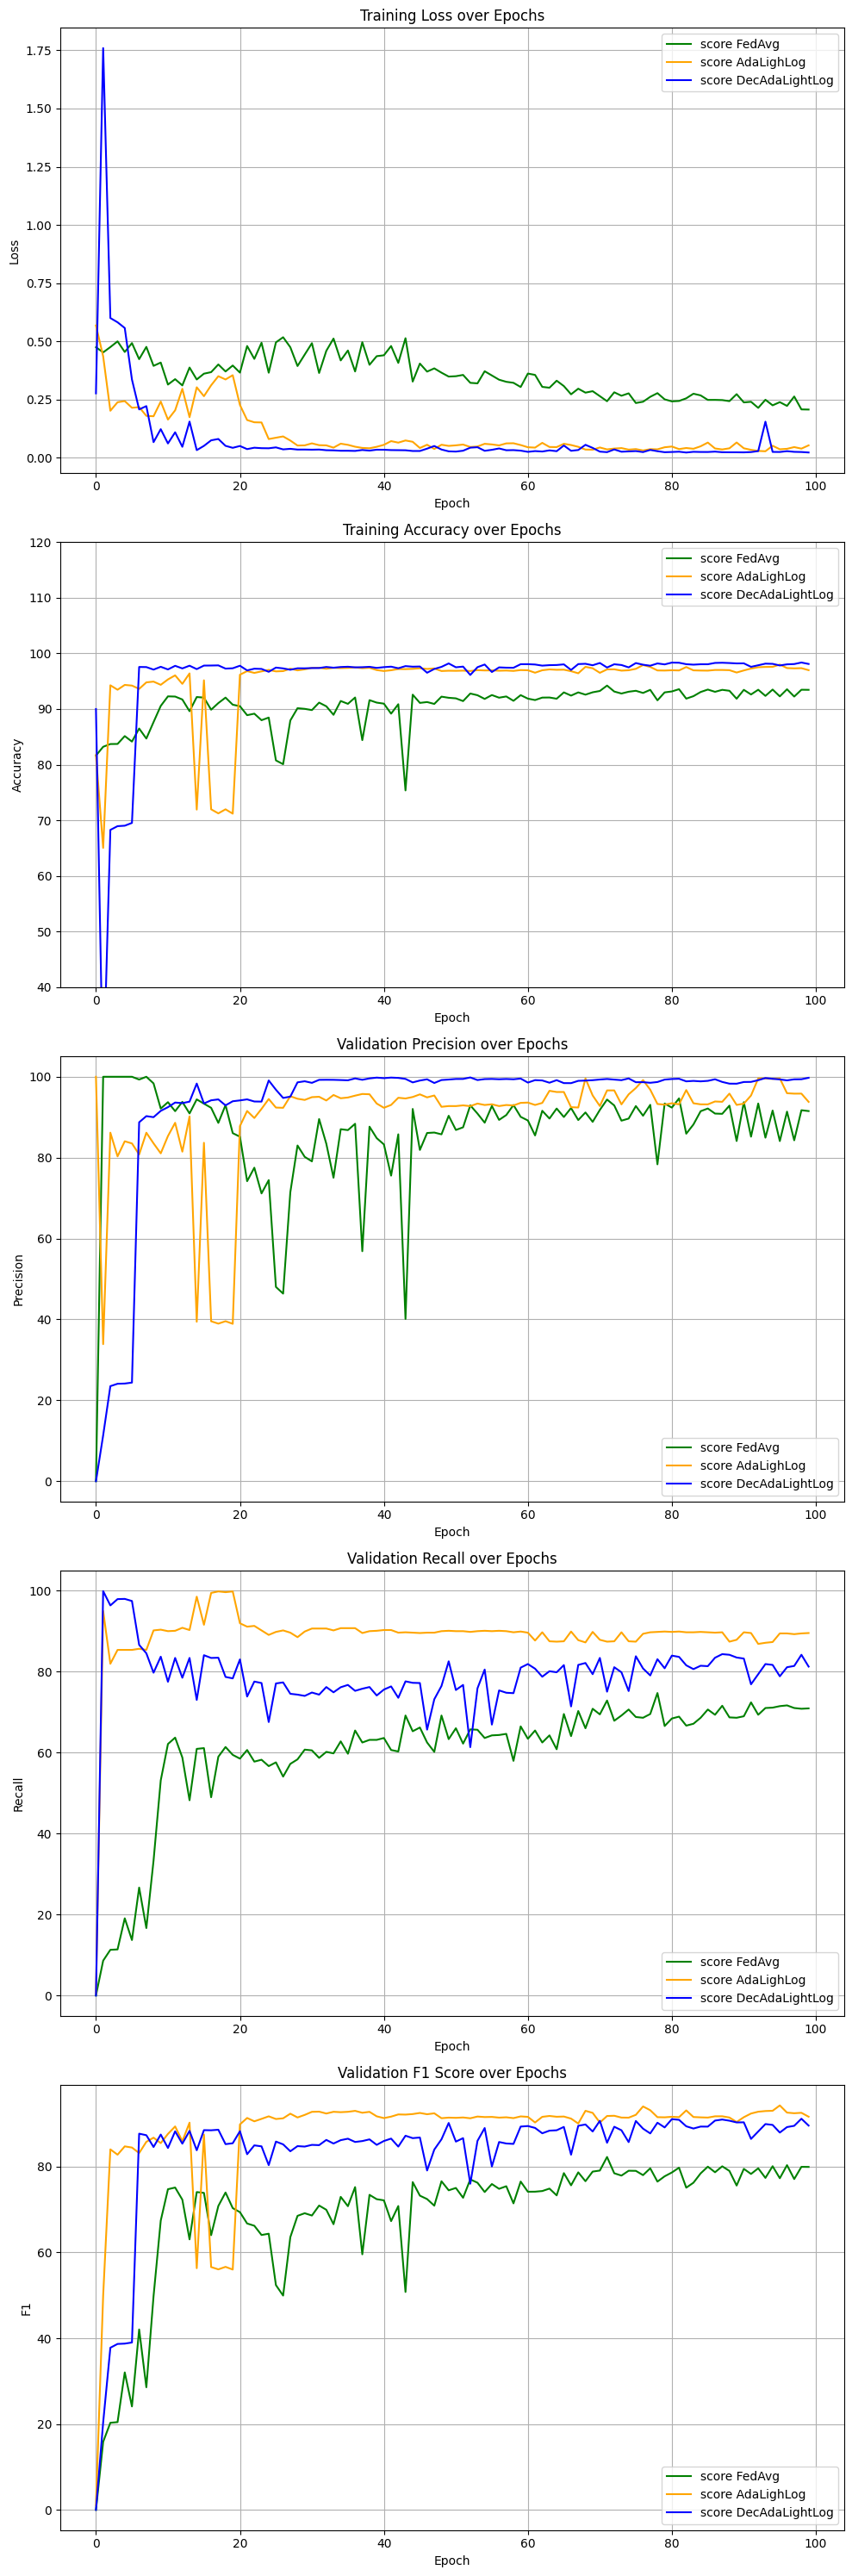

In [8]:
lr1 = "0.005"
ep1 = "100"

# FEDAVG PERFETTO QUESTO
sc1 = "no"
up1 = "no"
num1 = "02"
type1 = "AdaLightLog"

sc2 = "accuracy"
up2 = "f1"
num2 = "03"
type2 = "AdaLightLog"

sc3 = "no"
up3 = "f1"
num3 = "00"
type3 = "DecAdaLightLog"

compare_loaded_metrics(
    f'{tcn_models_dir}{type1}/FedAvg_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'{tcn_models_dir}{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'{tcn_models_dir}{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json'
)

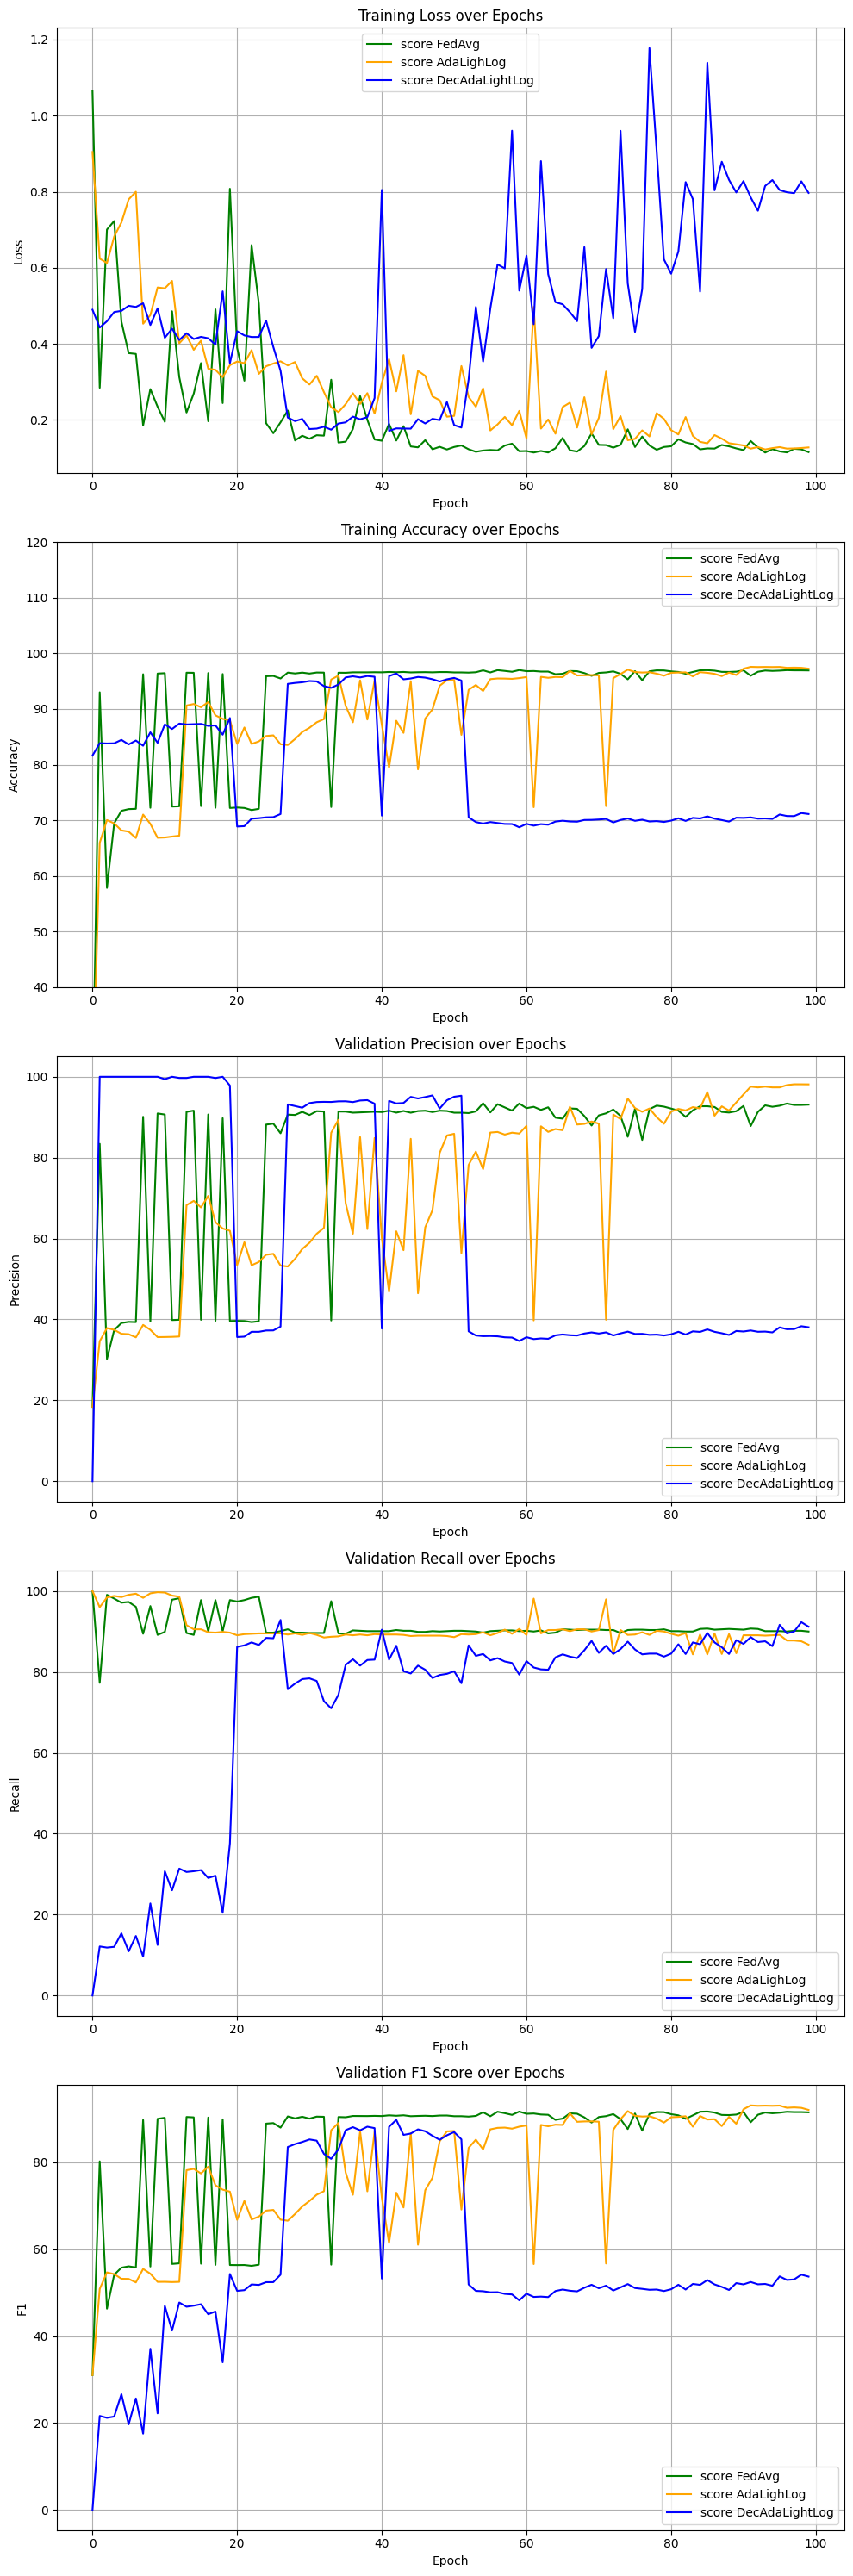

In [145]:
lr1 = "0.005"
ep1 = "100"

# FEDAVG PERFETTO QUESTO
sc1 = "no"
up1 = "no"
num1 = "05"
type1 = "DecAdaLightLog"

sc2 = "no"
up2 = "no"
num2 = "02"
type2 = "DecAdaLightLog"

sc3 = "no"
up3 = "no"
num3 = "06"
type3 = "DecAdaLightLog"
compare_loaded_metrics(
    f'{tcn_models_dir}{type1}/score={sc1}_update={up1}_lr={lr1}_epochs={ep1}_{num1}/metrics.json',
    f'{tcn_models_dir}{type2}/score={sc2}_update={up2}_lr={lr1}_epochs={ep1}_{num2}/metrics.json',
    f'{tcn_models_dir}{type3}/score={sc3}_update={up3}_lr={lr1}_epochs={ep1}_{num3}/metrics.json'
)

## Confusion Matrix

In [17]:
sc1 = "no"
up1 = "f1"
lr1 = "0.005"
ep1 = "100"
num1 = "01"

sc2 = "accuracy"
up2 = "f1"
lr2 = "0.005"
ep2 = "100"
num2 = "02"

lr3 = "0.005"
ep3 = "100"
num3 = "02"

type = "DecAdaLightLog"
#type = "AdaLightLog"
#type = "FedAvg"

if type=="DecAdaLightLog":
    model_path = f'Models/HDFS/TCN_models/{type}/score={sc1}_update={up1}_lr={lr1}_epochs={ep1}_{num1}/model.pth'
elif type=="AdaLightLog":
    model_path = f'Models/HDFS/TCN_models/{type}/score={sc2}_update={up2}_lr={lr2}_epochs={ep2}_{num2}/model.pth'
elif type=="FedAvg":
    model_path = f'Models/HDFS/TCN_models/AdaLightLog/FedAvg_lr={lr3}_epochs={ep3}_{num3}/model.pth'
else:
    raise ValueError(f'The model type {type} is not recognized. Possible models are:\nAdaLightLog;\nDecAdaLightLog;\nFedAvg')

# We consider the last model of the network
y_true = y_valid[-1]

start_data = time.perf_counter()
test_model, y_pred = get_predictions(
    x_valid[-1],\
    model_path,\
    input_size,\
    2,\
    device
)
end_data = time.perf_counter()
print(f'Predictions correctly computed in {end_data - start_data:.4f}s!')
'''
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
'''
accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())
precision = precision_score(y_true.cpu(), y_pred.cpu())
recall = recall_score(y_true.cpu(), y_pred.cpu())
f1 = f1_score(y_true.cpu(), y_pred.cpu())
TP = torch.sum((y_true == 1) & (y_pred == 1))
TP = torch.sum((y_true == 1) & (y_pred == 1))
FP = torch.sum((y_true == 0) & (y_pred == 1))
TN = torch.sum((y_true == 0) & (y_pred == 0))
FN = torch.sum((y_true == 1) & (y_pred == 0))

print(f'TN: {TN} | FP: {FP}')
print(f'FN: {FN}  | TP: {TP}')

prec = TP/(TP+FP)
print(f'Accuracy: {accuracy:.4f} (percentage value: {(accuracy*100):.2f}%)')
print(f'Precision: {precision:.4f} (percentage value: {(prec*100):.2f}%)')
print(f'Recall: {recall:.4f} (percentage value: {(recall*100):.2f}%)')
print(f'F1-score: {f1:.4f} (percentage value: {(f1*100):.2f}%)')


Predictions correctly computed in 0.0211s!
TN: 4782 | FP: 17
FN: 123  | TP: 957
Accuracy: 0.9762 (percentage value: 97.62%)
Precision: 0.9825 (percentage value: 98.25%)
Recall: 0.8861 (percentage value: 88.61%)
F1-score: 0.9318 (percentage value: 93.18%)


Normalized confusion matrix


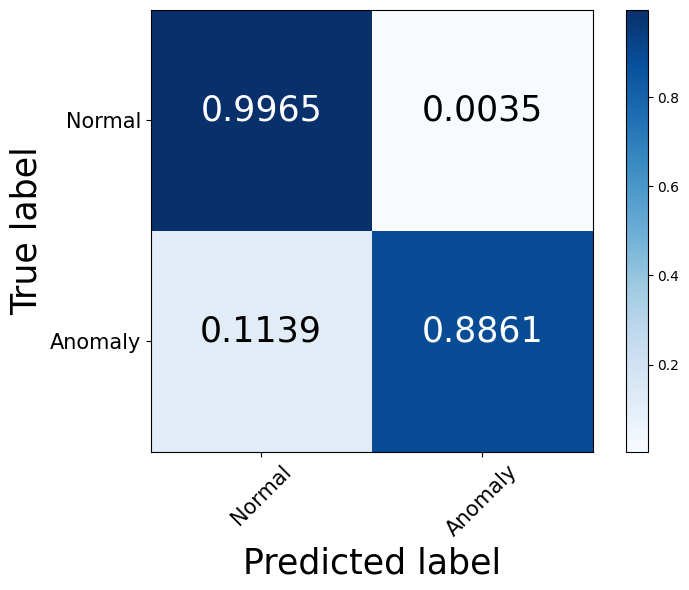

In [18]:
plot_confusion_matrix(
    y_true.cpu(),\
    y_pred.cpu(),\
    plots_dir,\
    classes=['Normal', 'Anomaly'],\
    normalize=True,\
    title=None,\
    fontsize=25,\
    type = type
)